In [1]:
import torch
from torch import nn
import numpy as np
import collections
import os
import time
import itertools
from scipy import linalg
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import matplotlib as mpl
import random
from shapely.geometry import Point
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KernelDensity
import gc
import math
import logging
import sys
import datetime
import pickle
from argparse import ArgumentParser
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable as V
from sklearn.metrics import silhouette_score
from matplotlib.ticker import PercentFormatter
import lime
from collections import Counter
from ipywidgets import interact
import pandas as pd
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import cartopy.feature
import cartopy.crs as ccrs

In [2]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
import umap
import os.path as osp
import matplotlib.patches as mpatches

In [3]:
os.environ['USER_PATH']='/home/richras/Ge3Net_Journal/Ge2Net_Repo/'
os.environ['USER_SCRATCH_PATH']="/home/richras/Ge3Net_Journal"
os.environ['OUT_PATH']='/home/richras/Ge3Net_Journal'
os.chdir(os.environ.get('USER_PATH'))

In [4]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy
from src.utils.modelUtil import Params, load_model, convert_coordinates
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr
from src.utils.decorators import timer
from src.models.modelSelection import modelSelect
from src.models.modelParamsSelection import Selections
from src.models import Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred, GcdLoss, class_accuracy
from src.main.settings_model import parse_args
from src.main.dataset import Haplotype
from src.models.Ge3Net import Ge3NetBase
from src.main.visualization import plot_changepoints
import inference
from src.main.evaluation import branchLoss, modelOuts
from src.models.MCDropout import MC_Dropout
from src.utils.dataUtil import square_normalize

In [5]:
%autosave 60

# set numpy and torch seed
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Autosaving every 60 seconds


In [6]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'], 'data','data_id_4_geo')
data_path = osp.join(os.environ['OUT_PATH'],'data','data_id_4_geo')
models_path=osp.join(os.environ['OUT_PATH'],'models','Model_Q_exp_id_3_data_id_4_geo/') 
dataset_type='test'

In [7]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
yaml_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(yaml_path), "No yaml configuration file found at {}".format(yaml_path)
params = Params(yaml_path)
params.rtnOuts=True
params.mc_dropout=False
params.mc_samples=100
params.cp_tol=1
params.valid_gens=[0,2,4,8]
params.evalCp=True
params.evalBalancedGcd=True
params.evalExtraMainLosses=True
params.pretrained=False
params.optimizer='AdamW'
results, test_dataset, model, _=inference.main(config, params)

 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (540, 317410)
INFO: __init__:src.main.dataset: y_labels data :(540, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0723 secs
Finished 'mapping_func' in 0.2731 secs
Finished 'pop_mapping' in 0.1024 secs
Finished 'pop_mapping' in 0.0951 secs
Finished 'transform_data' in 27.3777 secs
Finished '__init__' in 32.9012 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 1.6115 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prM

In [8]:
valid_dataset = Haplotype("valid", params, data_path, labels_path=labels_path)
train_dataset = Haplotype("train", params, data_path, labels_path=labels_path)

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (612, 317410)
INFO: __init__:src.main.dataset: y_labels data :(612, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0691 secs
Finished 'mapping_func' in 0.2668 secs
Finished 'pop_mapping' in 0.1019 secs
Finished 'pop_mapping' in 0.1116 secs
Finished 'transform_data' in 28.2531 secs
Finished '__init__' in 33.8854 secs


INFO: __init__:src.main.dataset: Loading train Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (4778, 317410)
INFO: __init__:src.main.dataset: y_labels data :(4778, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 16
INFO: __init__:src.main.dataset: snps data: (400, 317410)
INFO: __init__:src.main.dataset: y_labels data :(400, 317410)
INFO: __init__:src.main.dataset:Loading gen 24
INFO: __init__:src.main.dataset: snps data: (400, 317410)
INFO: _

Finished '_geoConvertLatLong2nVec' in 0.1865 secs
Finished 'mapping_func' in 0.6943 secs
Finished 'pop_mapping' in 0.2676 secs
Finished 'pop_mapping' in 0.2488 secs
Finished 'transform_data' in 75.1232 secs
Finished '__init__' in 89.7409 secs


In [9]:
 validation_generator = torch.utils.data.DataLoader(valid_dataset, batch_size=params.batch_size, num_workers=0, pin_memory=True)
    

In [10]:
mc_dropout = MC_Dropout(params.mc_samples, params.n_win, variance=True) if params.mc_dropout else None
model.eval()
with torch.no_grad():
    for i, val_gen in enumerate(validation_generator):
        val_x, val_y, vcf_idx, cps, superpop, granularpop = val_gen
        val_x = val_x.to(params.device).float()
        val_y = val_y.to(params.device).float()
        cps = cps.to(params.device).unsqueeze(2)
        cp_mask=(cps==0) if params.validCpMask else torch.ones_like(cps, device=params.device)
        val_labels = modelOuts(coord_main=val_y, cp_logits=cps.float()) #BCE needs float as target and not byte 
        val_aux1, _, _, val_aux4  = model.aux(val_x)
        val_mht = model.mht_encoder(val_aux1)
        val_vec_64, val_rnn, _ = model.lstm(val_mht)
        if i==0:
            val_aux_embed=val_aux1
            val_mht_embed=val_mht
            val_vec_64_embed=val_vec_64
            val_rnn_embed=val_rnn
        else:
            val_aux_embed=torch.cat([val_aux_embed,val_aux1])
            val_mht_embed=torch.cat([val_mht_embed, val_mht])
            val_vec_64_embed=torch.cat([val_vec_64_embed, val_vec_64])
            val_rnn_embed=torch.cat([val_rnn_embed, val_rnn])

In [11]:
val_aux1.shape, val_mht.shape, val_vec_64.shape, val_rnn.shape, val_aux_embed.shape, val_mht_embed.shape, \
val_vec_64_embed.shape, val_rnn_embed.shape

(torch.Size([196, 317, 100]),
 torch.Size([196, 317, 100]),
 torch.Size([196, 317, 64]),
 torch.Size([196, 317, 3]),
 torch.Size([3012, 317, 100]),
 torch.Size([3012, 317, 100]),
 torch.Size([3012, 317, 64]),
 torch.Size([3012, 317, 3]))

In [12]:
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=params.batch_size, num_workers=0, pin_memory=True)

In [13]:
mc_dropout = MC_Dropout(params.mc_samples, params.n_win, variance=True) if params.mc_dropout else None
model.eval()
with torch.no_grad():
    for i, test_gen in enumerate(test_generator):
        test_x, test_y, vcf_idx, cps, superpop, granularpop = test_gen
        test_x = test_x.to(params.device).float()
        test_y = test_y.to(params.device).float()
        cps = cps.to(params.device).unsqueeze(2)
        cp_mask=(cps==0) if params.validCpMask else torch.ones_like(cps, device=params.device)
        test_labels = modelOuts(coord_main=test_y, cp_logits=cps.float()) #BCE needs float as target and not byte 
        test_aux1, _, _, test_aux4  = model.aux(test_x)
        test_mht = model.mht_encoder(test_aux1)
        test_vec_64, test_rnn, _ = model.lstm(test_mht)
        if i==0:
            test_aux_embed=test_aux1
            test_mht_embed=test_mht
            test_vec_64_embed=test_vec_64
            test_rnn_embed=test_rnn
        else:
            test_aux_embed=torch.cat([test_aux_embed,test_aux1])
            test_mht_embed=torch.cat([test_mht_embed, test_mht])
            test_vec_64_embed=torch.cat([test_vec_64_embed, test_vec_64])
            test_rnn_embed=torch.cat([test_rnn_embed, test_rnn])

In [14]:
#save val emebddings
# path=osp.join(models_path,'validation_embeddings')
# with open (osp.join(path, 'validation_aux_embeddings.npy'), 'wb') as f:
#     np.save(f, val_aux_embed.cpu().detach().numpy())
# with open (osp.join(path, 'validation_mht_embeddings.npy'), 'wb') as f:
#     np.save(f, val_mht_embed.cpu().detach().numpy())
# with open (osp.join(path, 'validation_vec_64_embeddings.npy'), 'wb') as f:
#     np.save(f, val_vec_64_embed.cpu().detach().numpy())
# with open (osp.join(path, 'validation_rnn_embeddings.npy'), 'wb') as f:
#     np.save(f, val_rnn_embed.cpu().detach().numpy())

In [15]:
# test_path=osp.join(models_path,'test_embeddings' ,'test_embeddings.npy')
# with open (osp.join(path, 'test_aux_embeddings.npy'), 'wb') as f:
#     np.save(f, test_aux_embed.cpu().detach().numpy())
# with open (osp.join(path, 'test_mht_embeddings.npy'), 'wb') as f:
#     np.save(f, test_mht_embed.cpu().detach().numpy())
# with open (osp.join(path, 'test_vec_64_embeddings.npy'), 'wb') as f:
#     np.save(f, test_vec_64_embed.cpu().detach().numpy())
# with open (osp.join(path, 'test_rnn_embeddings.npy'), 'wb') as f:
#     np.save(f, test_rnn_embed.cpu().detach().numpy())

In [16]:
# continent_dict={k:v for k,v in zip(pop_list,np.arange(7))}
# continent_dict

In [17]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=valid_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
rev_sp_dict={v:k for k,v in superop_dict.items()}

In [18]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
for k,v in granular_pop_dict.items():
    if k.find("_")!=-1:
        granular_pop_dict[k.replace("_"," ")]=v
        del granular_pop_dict[k]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
rev_sp_dict={v:k for k,v in superop_dict.items()}

In [19]:
granularpopTest=test_dataset.data['granular_pop'].reshape(-1,)
print(granularpopTest.shape)
granularpopTestNames=[rev_pop_dict[i] for i in granularpopTest.astype(int)]
print(len(granularpopTestNames))

(931980,)
931980


In [20]:
labels_all=load_path(osp.join(labels_path, 'labels.pkl'), en_pickle=True)
train_sample_map=pd.read_csv(osp.join(labels_path, 'train_sample_map.tsv'), sep="\t")
pop_arr_train = repeat_pop_arr(train_sample_map)
n_dim=2
labelsTrainArr=np.zeros((len(pop_arr_train), n_dim))
for i,j in enumerate(pop_arr_train[:,1]):
    labelsTrainArr[i,:]=labels_all.get(j) #5930x3 #samplesxdim
df_trainLabels=pd.DataFrame(labelsTrainArr)
df_trainLabels=df_trainLabels.drop_duplicates()
results_coord_main=results.t_out.coord_main.mean(0)
print(results_coord_main.shape)
pred_coord_all=convert_coordinates(results_coord_main[...,0], results_coord_main[...,1], results_coord_main[...,2])
pred_coord_all = pred_coord_all.reshape(-1,2)
print(pred_coord_all.shape)

(2940, 317, 3)
(931980, 2)


In [21]:
values=['Japanese', 'Papuan Sepik', 'Kinh Vietnamese','Indian Telugu', 'Brahui','Yakut','Eskimo Chaplin',\
     'Pima', 'Surui', 'Esan', 'Yoruba', 'Druze', 'Finnish', 'San','Spanish','Tuscan', 'Northern Han',\
       'Luhya', 'Maya']
index=[89177,28932, 28054,70538, 98122, 2652, 3034, 43188, 39211, 41381, 69208, 3980, 8480,12237, 432855,\
      57621, 99766, 89969, 61305]
annotate_dict={k:v for k,v in zip(index,values)}

In [22]:
annotate_dict[98122]

'Brahui'

In [23]:
print(len(index))

19


In [24]:
def decompose_embedding(Standardized_data,embed_type='pca'):
    n_neighbors=30
    print(Standardized_data.shape)
    if embed_type=='pca':
        pca=decomposition.PCA(whiten=True)
        pca.n_components=3
        pca_data=pca.fit_transform(Standardized_data)
        percentage_var_explained=["%.2f" % member for member in pca.explained_variance_ratio_]
        print(f'explained_variance_ratio_:{percentage_var_explained}')
        return pca_data
    elif embed_type=='tsne':
        tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
        X_tsne = tsne.fit_transform(Standardized_data)
        return X_tsne
    elif embed_type=='mds':
        clf = manifold.MDS(n_components=3, n_init=1, max_iter=100)
        X_mds = clf.fit_transform(Standardized_data)
        print("Done. Stress: %f" % clf.stress_)
        return X_mds
    elif embed_type=='Isomap':
        X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=3).fit_transform(Standardized_data)
        return X_iso
    elif embed_type=='spectral':
        embedder = manifold.SpectralEmbedding(n_components=3, random_state=0,
                                      eigen_solver="arpack")
        X_se = embedder.fit_transform(Standardized_data)
        return X_se
    elif embed_type=='random_trees':
        hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
        X_transformed = hasher.fit_transform(Standardized_data)
        pca = decomposition.TruncatedSVD(n_components=3)
        X_reduced = pca.fit_transform(X_transformed)
        return X_reduced
    elif embed_type=='ltsa':
        clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=3,
                                      method='ltsa')
        X_ltsa = clf.fit_transform(Standardized_data)
        print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
        return X_ltsa
    elif embed_type=='hlle':
        clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=3,
                                      method='hessian')

        X_hlle = clf.fit_transform(Standardized_data)
        print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
        return X_hlle
    elif embed_type=='mlle':
        clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=3,
                                      method='modified')
        X_mlle = clf.fit_transform(Standardized_data)
        print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
        return X_mlle
    elif embed_type=='lle':
        clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=3,
                                      method='standard')
        X_lle = clf.fit_transform(Standardized_data)
        print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
        return X_lle
    elif embed_type=='umap':
        X_umap=umap.UMAP(n_components=3, n_neighbors=1000).fit_transform(Standardized_data)
        return X_umap
        

In [25]:
pca_val_aux=decompose_embedding(val_aux_embed.cpu().detach().numpy().reshape(-1,100))
pca_val_mht=decompose_embedding(val_mht_embed.cpu().detach().numpy().reshape(-1,100))
pca_val_vec_64=decompose_embedding(val_vec_64_embed.cpu().detach().numpy().reshape(-1,64))

(954804, 100)
explained_variance_ratio_:['0.14', '0.06', '0.05']
(954804, 100)
explained_variance_ratio_:['0.36', '0.20', '0.16']
(954804, 64)
explained_variance_ratio_:['0.27', '0.19', '0.14']


In [26]:
superpopsValid=valid_dataset.data['superpop'].reshape(-1,)

In [27]:
superpopsValid.shape

(954804,)

In [28]:
anno_values=['Japanese', 'PapuanHighlands', 'Kinh Vietnamese','Bengali', 'Brahui','Yakut',\
     'Pima', 'Surui', 'Esan', 'Yoruba', 'Druze', 'Finnish','Spanish','Tuscan', 'NorthernHan',\
       'Luhya', 'Mozabite','Karitiana','Mbuti']

In [29]:
granular_pop_dict

{'British': 0,
 'Finnish': 1,
 'Southern Han Chinese': 2,
 'Dai Chinese': 3,
 'Spanish': 4,
 'Peruvian': 5,
 'Punjabi': 6,
 'Kinh Vietnamese': 7,
 'Gambian Mandinka': 8,
 'Esan': 9,
 'Bengali': 10,
 'Mende': 11,
 'Sri Lankan': 12,
 'Indian Telugu': 13,
 'Yoruba': 14,
 'Han Chinese': 15,
 'Japanese': 16,
 'Luhya': 17,
 'Mexican-American': 18,
 'Tuscan': 19,
 'Gujarati': 20,
 'Brahui': 21,
 'Balochi': 22,
 'Hazara': 23,
 'Makrani': 24,
 'Sindhi': 25,
 'Pathan': 26,
 'Kalash': 27,
 'Burusho': 28,
 'Mbuti': 29,
 'Biaka': 30,
 'Bougainville': 31,
 'French': 32,
 'PapuanSepik': 33,
 'PapuanHighlands': 34,
 'Druze': 35,
 'Bedouin': 36,
 'Sardinian': 37,
 'Palestinian': 38,
 'Colombian': 39,
 'Cambodian': 40,
 'Han': 41,
 'Orcadian': 42,
 'Surui': 43,
 'Maya': 44,
 'Russian': 45,
 'Mandenka': 46,
 'Yakut': 47,
 'San': 48,
 'BantuSouthAfrica': 49,
 'Karitiana': 50,
 'Pima': 51,
 'Tujia': 52,
 'Yi': 54,
 'Miao': 55,
 'Oroqen': 56,
 'Daur': 57,
 'Mongolian': 58,
 'Hezhen': 59,
 'Xibo': 60,
 'Moza

In [30]:
anno_pops=[granular_pop_dict[i] for i in anno_values]

In [31]:
anno_idx=[]
for i in anno_pops:
    print(rev_pop_dict[i])
    print(np.where(granularpopTest==i))
    specific_pop=np.where(granularpopTest==i)[0]
    print(np.random.choice(specific_pop,1))
    anno_idx.append(np.random.choice(specific_pop,1)[0])

Japanese
(array([ 95100,  95101,  95102, ..., 931272, 931273, 931274]),)
[650620]
PapuanHighlands
(array([138212, 138213, 138214, ..., 897107, 897108, 897109]),)
[212998]
Kinh Vietnamese
(array([ 38040,  38041,  38042, ..., 929433, 929434, 929435]),)
[898778]
Bengali
(array([ 57694,  57695,  57696, ..., 930639, 930640, 930641]),)
[840211]
Brahui
(array([122996, 122997, 122998, ..., 910372, 910373, 910374]),)
[651389]
Yakut
(array([154696, 154697, 154698, ..., 929758, 929759, 929760]),)
[536978]
Pima
(array([156598, 156599, 156600, ..., 922072, 922073, 922074]),)
[156819]
Surui
(array([151526, 151527, 151528, ..., 920024, 920025, 920026]),)
[431786]
Esan
(array([ 51354,  51355,  51356, ..., 931529, 931530, 931531]),)
[290657]
Yoruba
(array([ 80518,  80519,  80520, ..., 931257, 931258, 931259]),)
[750174]
Druze
(array([138846, 138847, 138848, ..., 928490, 928491, 928492]),)
[376960]
Finnish
(array([  5706,   5707,   5708, ..., 931966, 931967, 931968]),)
[455688]
Spanish
(array([ 24092,  

In [32]:
def formColorMapBySP(superop_dict):
    continentalPops=[superop_dict['EUR'], superop_dict['EAS'], superop_dict['OCE'], superop_dict['SAS'],\
                 superop_dict['AFR'], superop_dict['AMR'], superop_dict['WAS']]
    colors_pop = sns.color_palette("bright", 10)
    del colors_pop[1]
    del colors_pop[4]
    del colors_pop[5]
    colors_pop_dict = {k:v for k,v in zip(continentalPops, colors_pop)}
    return colors_pop_dict

In [33]:
def plot_embeddings(embed_data, superop_dict, superpopsTrue, **kwargs):
    fig=plt.figure(figsize=(20,12))
    plt.rcParams['savefig.transparent'] = True
    ax= Axes3D(fig)
    ax = fig.gca(projection='3d')
    colors_pop_dict=formColorMapBySP(superop_dict)
    patches=[]
    for k, val in superop_dict.items():
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
    lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))
    alpha=[1.0]*len(embed_data)
    ax.scatter(embed_data[:,0], embed_data[:,1], embed_data[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(superpopsTrue, alpha)],s = 0.005)
    #annotate selected predictions
    if kwargs.get('anno_enable')is not None:
        for i in anno_idx:
            ax.text(embed_data[i,0], embed_data[i,1], embed_data[i,2], s=granularpopTestNames[i], fontsize=15)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis("off")
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    ax.set_axis_off()
    # ax.view_init(30, 30)
    # ax.azim=-5
    plt.show()

(954804, 1000)
explained_variance_ratio_:['0.03', '0.02', '0.01']


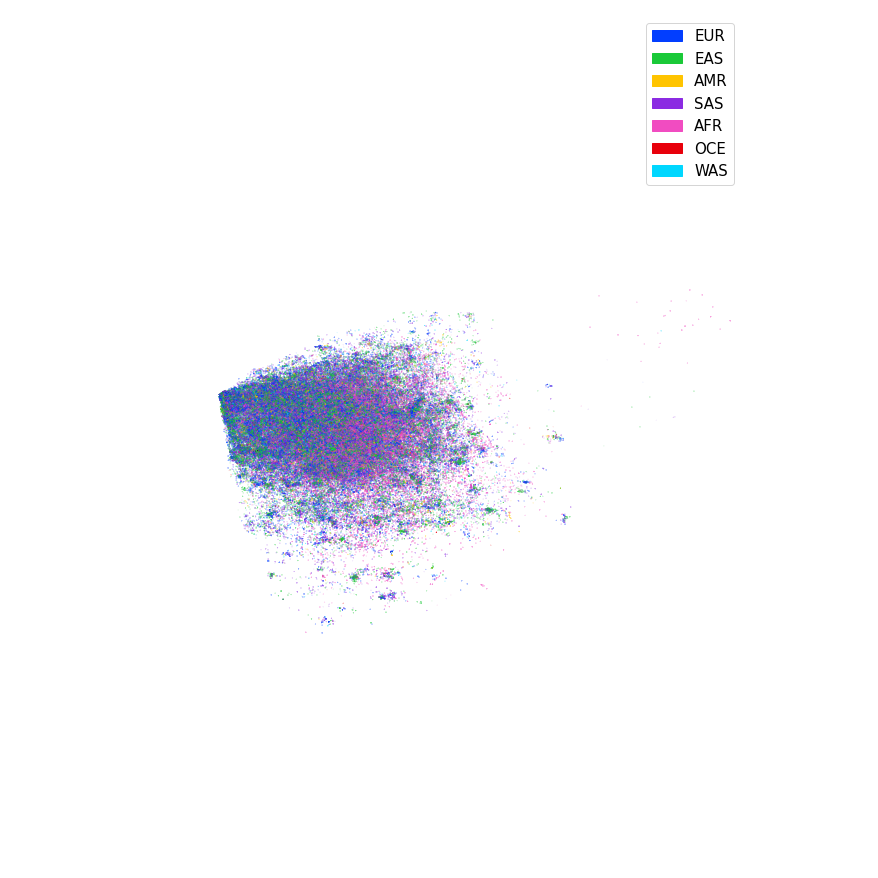

In [34]:
raw_data = valid_dataset.data['X'].reshape(-1, params.n_win, params.win_size)
raw_data_embed=decompose_embedding(raw_data.reshape(-1, params.win_size))
plot_embeddings(raw_data_embed, superop_dict, superpopsValid)

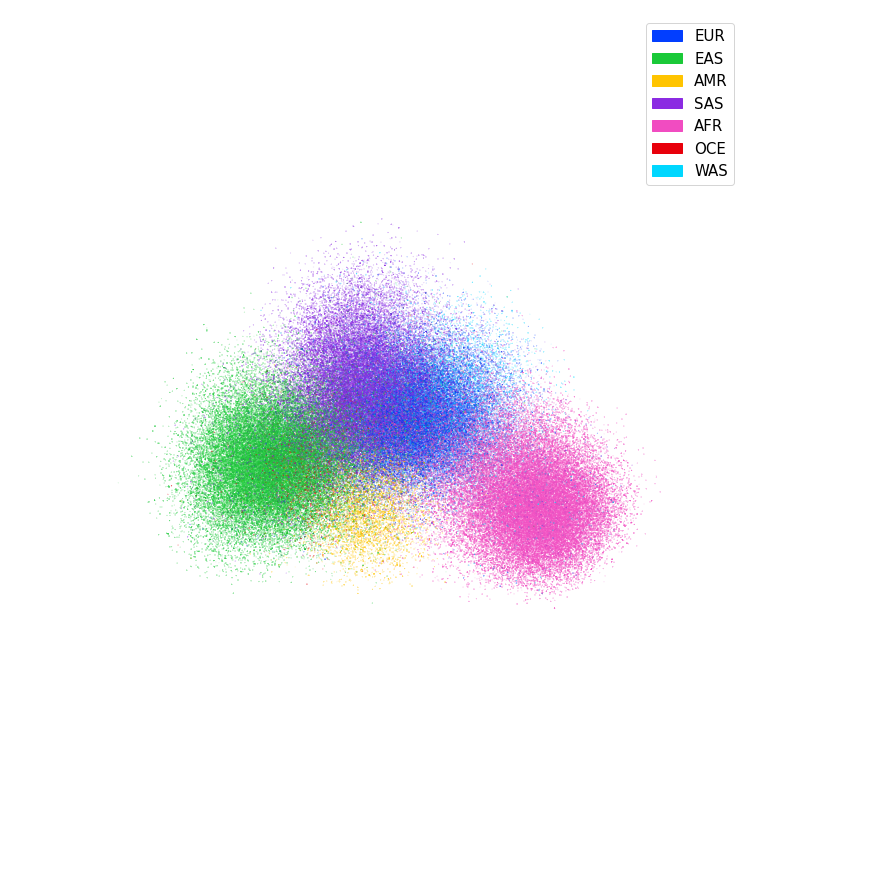

In [35]:
plot_embeddings(pca_val_aux, superop_dict, superpopsValid)

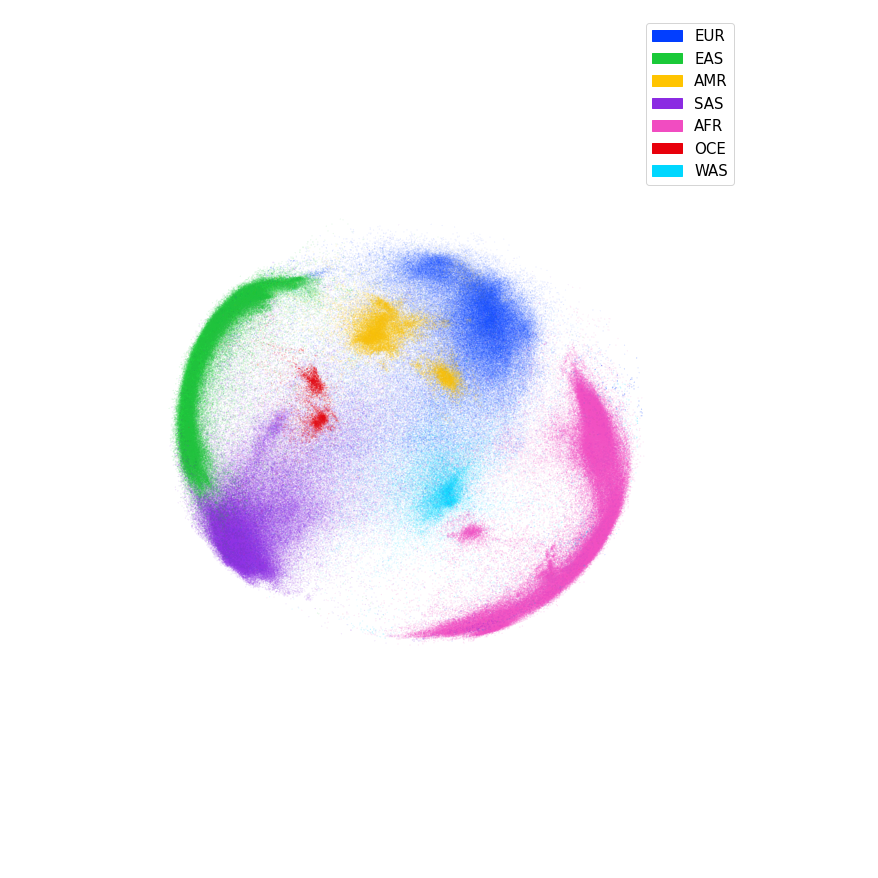

In [36]:
plot_embeddings(pca_val_mht, superop_dict, superpopsValid)

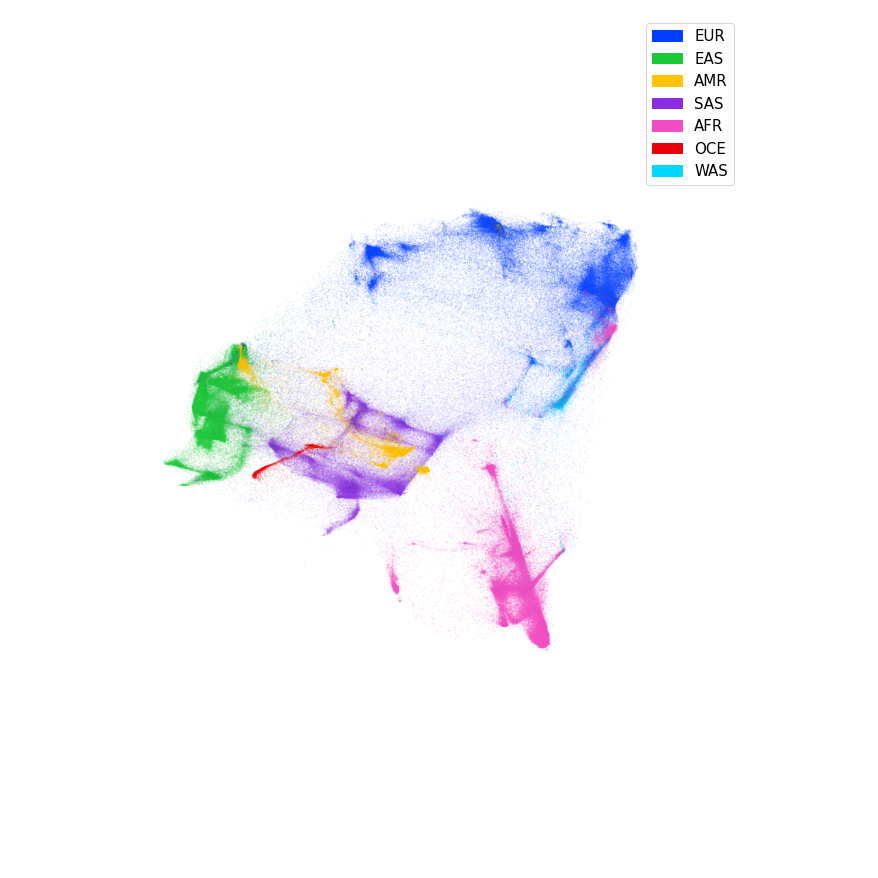

In [37]:
plot_embeddings(pca_val_vec_64, superop_dict, superpopsValid)

In [38]:
pca_test_aux=decompose_embedding(test_aux_embed.cpu().detach().numpy().reshape(-1,100))
pca_test_mht=decompose_embedding(test_mht_embed.cpu().detach().numpy().reshape(-1,100))
pca_test_vec_64=decompose_embedding(test_vec_64_embed.cpu().detach().numpy().reshape(-1,64))

(931980, 100)
explained_variance_ratio_:['0.14', '0.06', '0.05']
(931980, 100)
explained_variance_ratio_:['0.36', '0.21', '0.15']
(931980, 64)
explained_variance_ratio_:['0.27', '0.18', '0.14']


In [39]:
superpopsTest=test_dataset.data['superpop'].reshape(-1,)

In [40]:
superpopsTest.shape

(931980,)

In [41]:
np.where(test_dataset.data['granular_pop']==11)

(array([ 198,  198,  198, ..., 2939, 2939, 2939]),
 array([  0,   1,   2, ..., 314, 315, 316]))

(931980, 1000)
explained_variance_ratio_:['0.03', '0.02', '0.01']


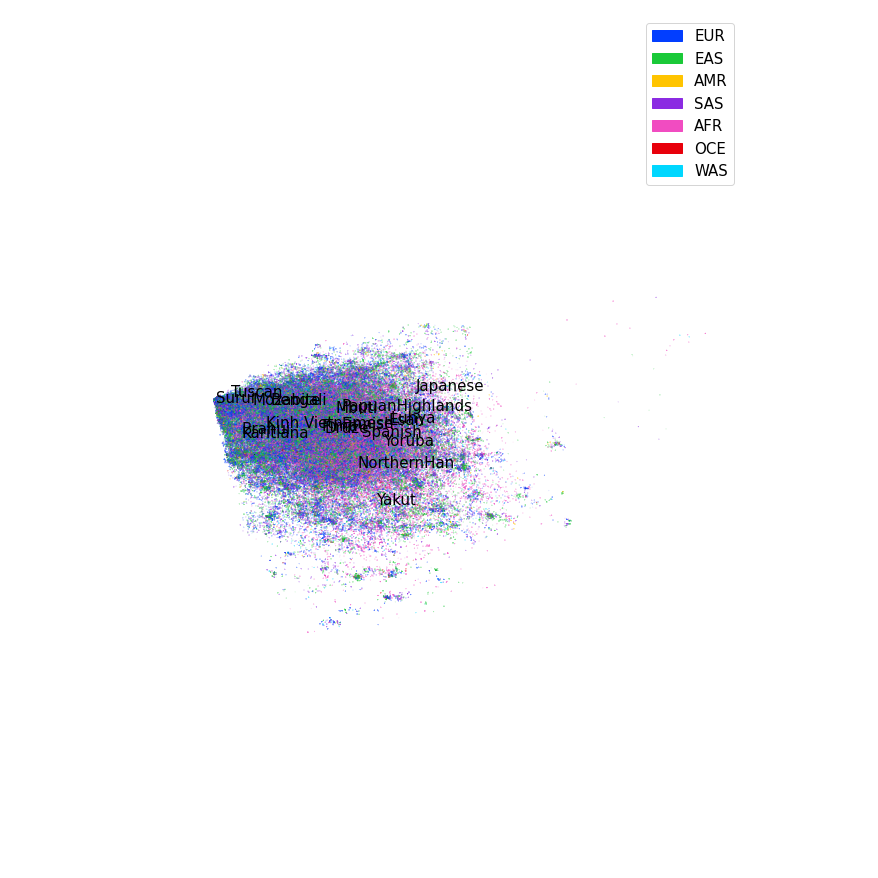

In [42]:
raw_data = test_dataset.data['X'].reshape(-1, params.n_win, params.win_size)
raw_data_embed=decompose_embedding(raw_data.reshape(-1, params.win_size))
plot_embeddings(raw_data_embed, superop_dict, superpopsTest, anno_enable=True)

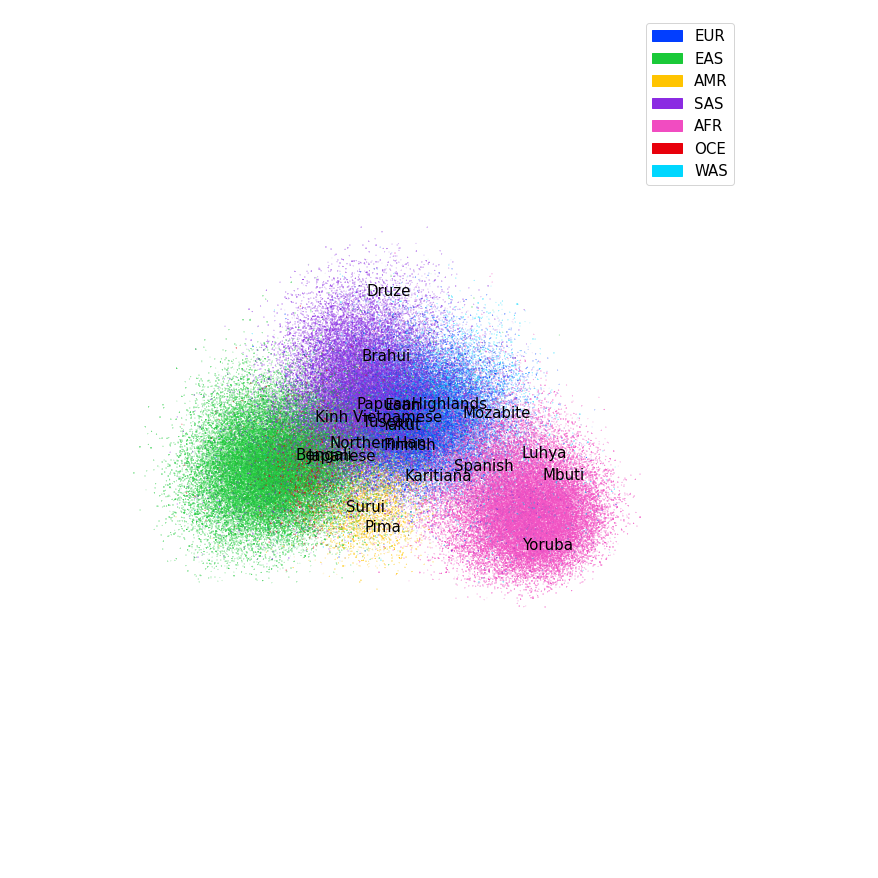

In [43]:
plot_embeddings(pca_test_aux, superop_dict, superpopsTest, anno_enable=True)

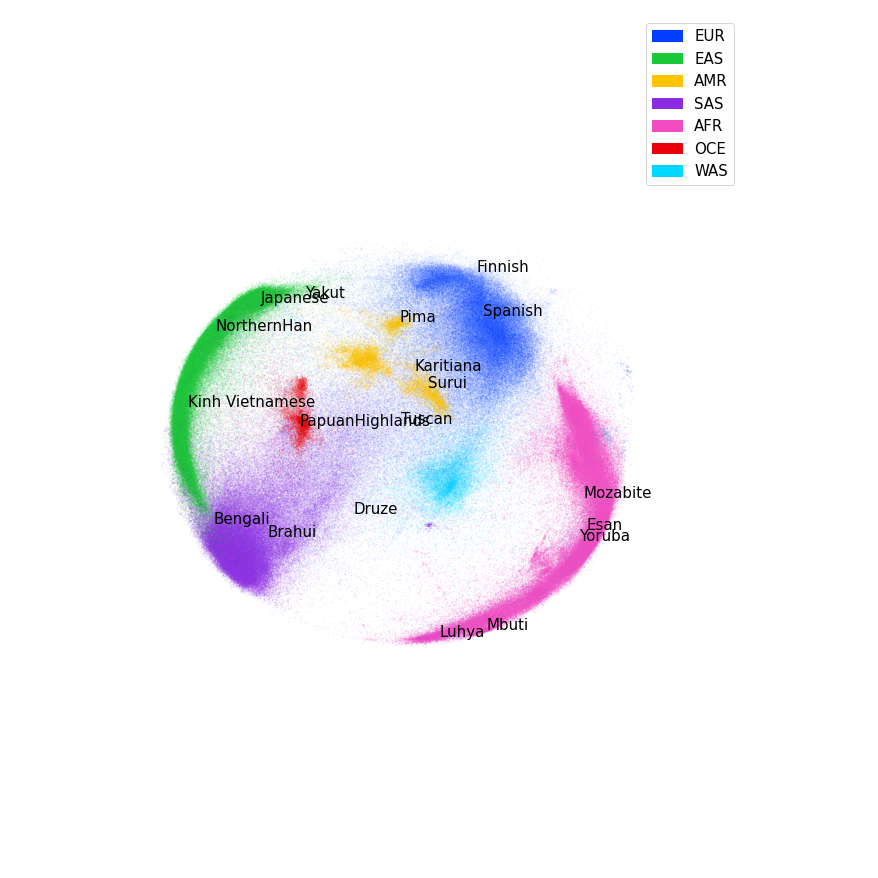

In [44]:
plot_embeddings(pca_test_mht, superop_dict, superpopsTest, anno_enable=True)

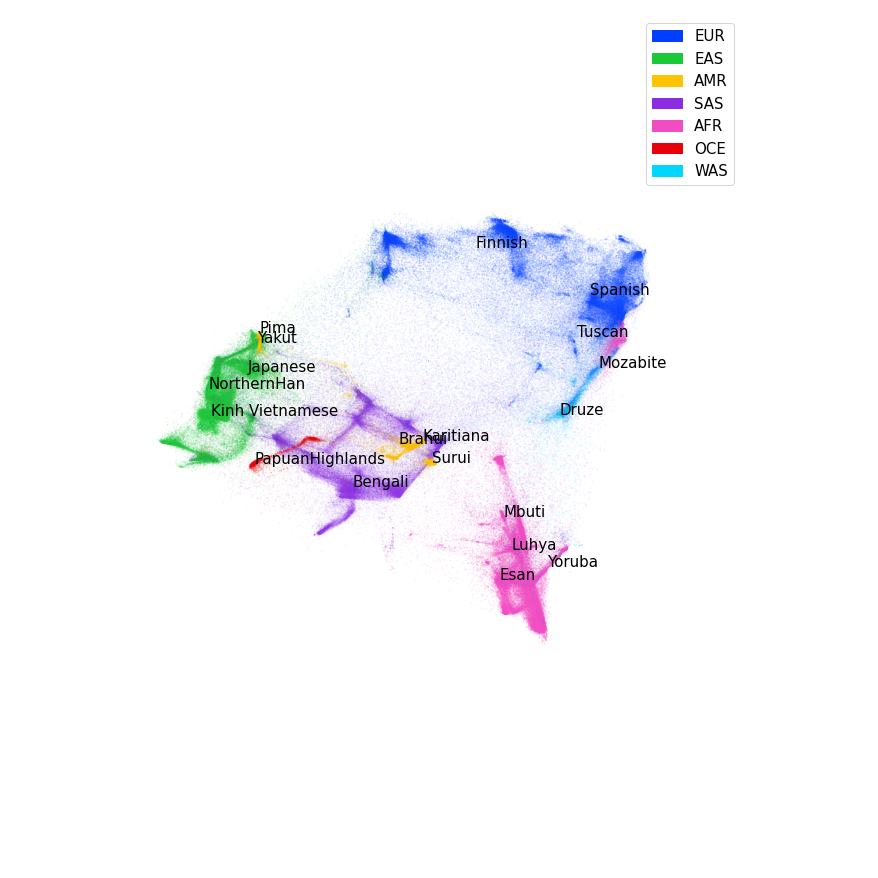

In [45]:
plot_embeddings(pca_test_vec_64, superop_dict, superpopsTest, anno_enable=True)

In [46]:
results.t_out.coord_main.shape

(1, 2940, 317, 3)

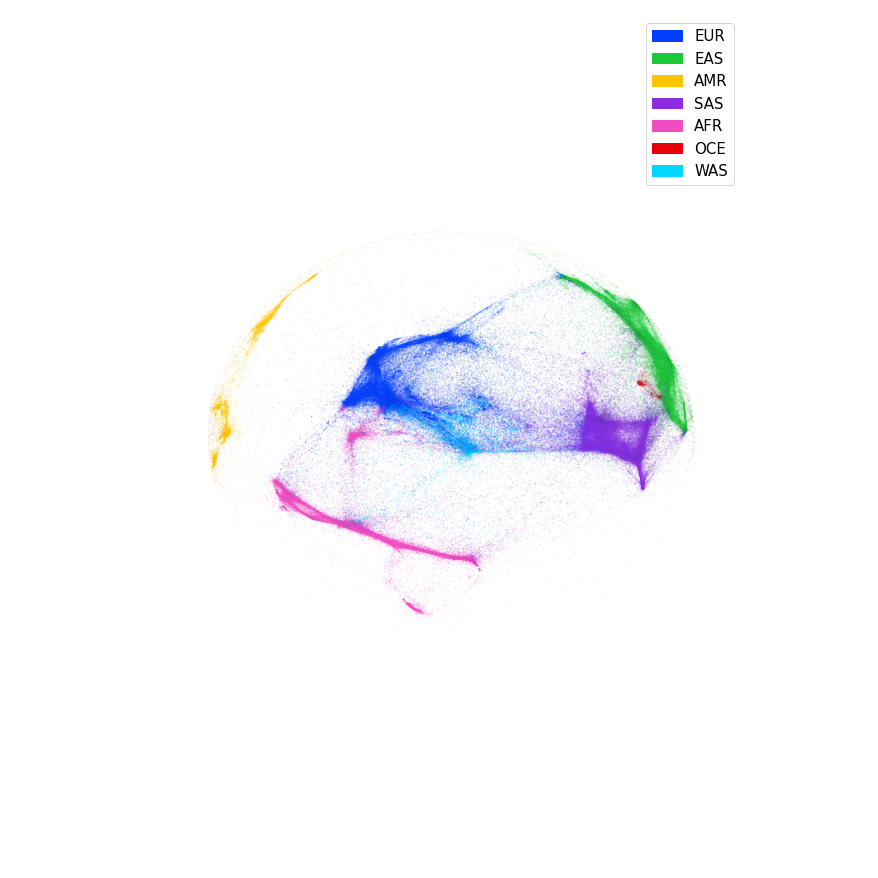

In [47]:
val_out = square_normalize(val_rnn_embed).cpu().detach().numpy().reshape(-1,3)
fig=plt.figure(figsize=(20,12))
plt.rcParams['savefig.transparent'] = True
ax= Axes3D(fig)
ax = fig.gca(projection='3d')
colors_pop_dict=formColorMapBySP(superop_dict)
patches=[]
for k, val in superop_dict.items():
    patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))
alpha=[1.0]*len(val_out)
ax.scatter(val_out[:,0], val_out[:,1], val_out[:,2], \
           color = [colors_pop_dict[x]+(y,) for x,y in zip(superpopsValid, alpha)],s = 0.005)

ax.set_yticks([])
ax.set_xticks([])
ax.axis("off")
fig.patch.set_visible(False)
ax.patch.set_visible(False)
ax.set_axis_off()
ax.view_init(30, 30)
# ax.azim=-5
plt.show()

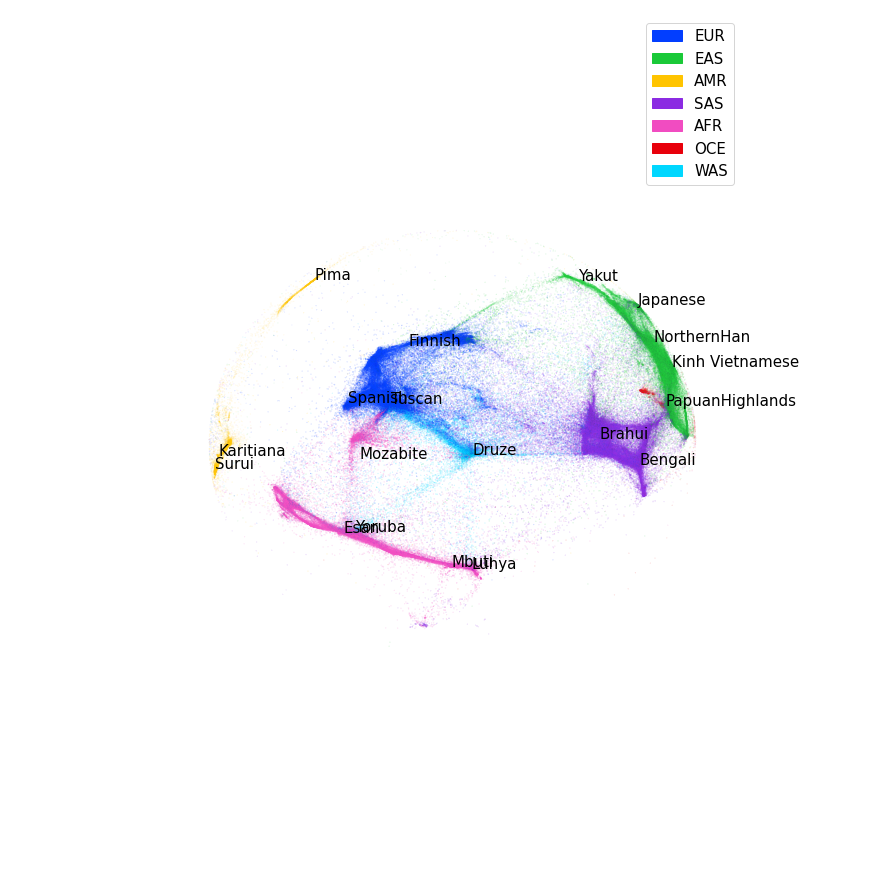

In [48]:
anno_enable=True
test_out = square_normalize(test_rnn_embed).cpu().detach().numpy().reshape(-1,3)
fig=plt.figure(figsize=(20,12))
plt.rcParams['savefig.transparent'] = True
ax= Axes3D(fig)
ax = fig.gca(projection='3d')
colors_pop_dict=formColorMapBySP(superop_dict)
patches=[]
for k, val in superop_dict.items():
    patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))
alpha=[1.0]*len(test_out)
ax.scatter(test_out[:,0], test_out[:,1], test_out[:,2], \
           color = [colors_pop_dict[x]+(y,) for x,y in zip(superpopsTest, alpha)],s = 0.005)
#annotate selected predictions
if anno_enable:
    for i in anno_idx:
        ax.text(test_out[i,0], test_out[i,1], test_out[i,2], s=granularpopTestNames[i], fontsize=15)
ax.set_yticks([])
ax.set_xticks([])
ax.axis("off")
fig.patch.set_visible(False)
ax.patch.set_visible(False)
ax.set_axis_off()
ax.view_init(30, 30)
# ax.azim=-5
plt.show()

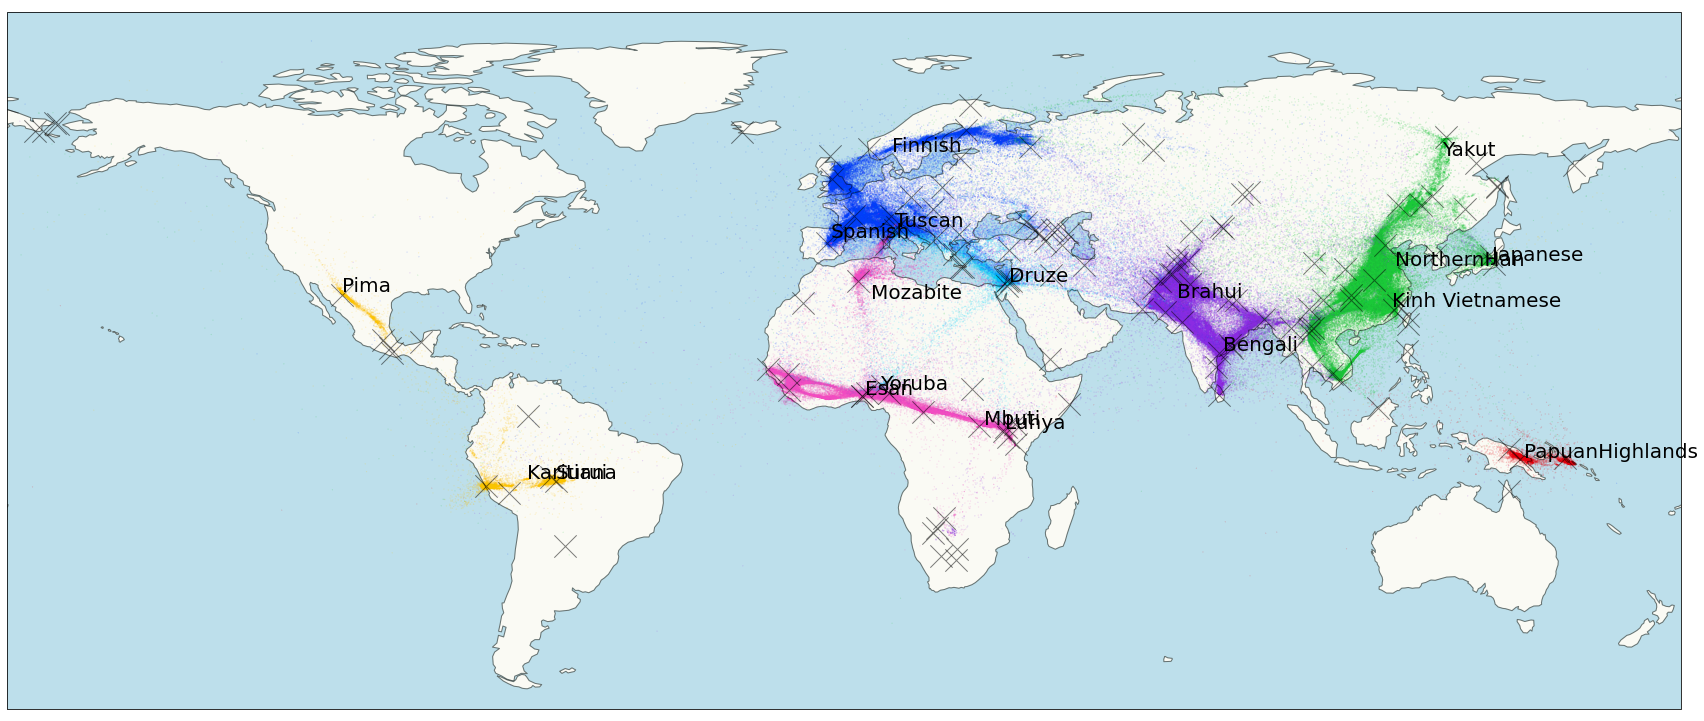

In [55]:
anno_enable=True
fig, ax = plt.subplots(figsize=(30,13))
gs1 = fig.add_gridspec(nrows=1, ncols=1)
ax1=fig.add_subplot(gs1[0],projection=ccrs.PlateCarree())
for axis in [ax]:
    axis.set_yticks([])
    axis.spines['top'].set_color('none')
    axis.spines['left'].set_color('none')
    axis.spines['right'].set_color('none')
ax.set_xticks([])
ax.set_yticks([])
plt.subplots_adjust(hspace=0.01)

ax1.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"), alpha=0.8)
ax1.add_feature(cartopy.feature.LAND, alpha =0.3)
ax1.add_feature(cartopy.feature.COASTLINE, alpha =0.5)

ax1.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
colors_pop_dict=formColorMapBySP(superop_dict)
patches=[]
for k, val in superop_dict.items():
    patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))
alpha=[1.0]*len(test_out)
ax1.scatter(pred_coord_all[:,1], pred_coord_all[:,0], \
           color = [colors_pop_dict[x]+(y,) for x,y in zip(superpopsTest, alpha)],s = 0.005)
#annotate selected predictions
if anno_enable:
    for i in anno_idx:
        ax1.text(pred_coord_all[i,1], pred_coord_all[i,0], s=granularpopTestNames[i], fontsize=20)
#training locations
ax1.scatter(df_trainLabels[1].values, df_trainLabels[0].values, transform=ccrs.PlateCarree(),\
           color = 'black', marker='x', s=500, linewidth=1, alpha=0.5)
ax.axis("off")


plt.show()

## Training locations

In [50]:
# train_out = train_dataset.data["y"].reshape(-1,3)
# superpopsTrain=train_dataset.data["superpop"].reshape(-1,)
# fig=plt.figure(figsize=(20,12))
# plt.rcParams['savefig.transparent'] = True
# ax= Axes3D(fig)
# ax = fig.gca(projection='3d')
# continentaPops=list(superop_dict.values())
# colors_pop = sns.color_palette("bright", 10)
# del colors_pop[1]
# del colors_pop[4]
# del colors_pop[5]
# colors_pop_dict = {k:v for k,v in zip(continentaPops, colors_pop)}
# patches=[]
# for k, val in superop_dict.items():
#     patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
# lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))
# alpha=[1.0]*len(train_out)
# ax.scatter(train_out[:,0], train_out[:,1], train_out[:,2], \
#            color = [colors_pop_dict[x]+(y,) for x,y in zip(superpopsTrain, alpha)],s = 5)

# ax.set_yticks([])
# ax.set_xticks([])
# ax.axis("off")
# fig.patch.set_visible(False)
# ax.patch.set_visible(False)
# ax.set_axis_off()
# ax.view_init(30, 30)
# # ax.azim=-5
# plt.show()